In [1]:
import allel
import msprime
import tskit
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG #, set_matplotlib_formats
from matplotlib import pyplot as plt
#jupyter magic
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import time

In [2]:
!wget --no-check-certificate 'https://www.dropbox.com/scl/fi/c677k4cwysifazgyh4vm3/p5_data_2024.zip?rlkey=gs48i6xckqntscesi7upglto5&dl=0' -q -O p5_data_2024.zip

In [3]:
! unzip p5_data_2024.zip

Archive:  p5_data_2024.zip
replace p5_data_2024/heli_chrom18.vcf.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
import sys; sys.path.insert(0,'./p5_data_2024/')
import sf_functions as sf

# Practical 6. Detecting selective sweeps in population genomic data

At the end of this practical you should:

- Understand how positive selection acts to favor a beneficial mutation  
- Understand the role of drift/randomness on allele frequency trajectories and fixation probability
- Understand the effect of positive selection on linked neutral variation
- Understand how sweepfinder works using simulation data
- Be able to perform a Selective sweep scan on real data

# 6.1 The direct effect of selection on a new mutation

We have so far considered the ancestry of samples backwards in time, and, in practical 2, have writen a simple coalescence time simulator in python. In this practical, we study the effect of positive selection on a focal *de novo* mutation. It is easiest to first think about the allele frequency trajectory of a new mutation forwards in time. 

Let's start by implementing a simple forwards in time simulation for the frequency trajectory of a new mutation under the neutral Wright Fisher (WF) model. We can then update this code to model positive selection acting on the new allele, and compare the dynamics of neutral and beneficial alleles.

### 6.1.1 Simulating drift fowards in time 

<div class="alert alert-block alert-info">
    <b>PopGen: Neutral Wright Fisher model</b> 
    
You should already be familiar with the neutral WF model (see Peter's population genetics lectures and PGA lecture 5). Consider a haploid population of $N_e$ individuals reproducing according to the WF model. We want to simulate the frequency trajectory of a *de novo* neutral mutation that appears in an individual.

In this model, each individual contributes on-average one offspring to the next generation. However, there is variance in offspring number: some individuals have 2, 3, or more children. And many will have no offspring at all.

From a coalescent perspective, we can think of this as each individual giving birth at the same _rate_, $1$. The next generation is formed by randomly assigning a parent to each offspring with probability $p = 1/N_e$, i.e. the rate of birth of the focal individual $1$ relative to the total birth rate in the population $N_e$.

Therefore, the frequency $k$ of the new mutation in the next generation, i.e. the probability that the focal individual has $k$ offspring, can be obtained simply by binomial sampling with "success probability" $p = 1/N_e$. 

$$P[k] = \binom{N_e}{k} p^k ( 1- p)^{N_e - k}$$

Furthermore, when $X$ individuals currently carry the new mutation, mutant individuals give birth with a total rate $X$. The probability of observing $k$ offspring is still binomially distributed but with $p=\frac{X}{N_e}$.  

By repeatedly drawing a random number of offspring and updating the probability $p$ of inheriting the new mutation, we can simulate the frequency trajectory of this mutation from generation to generation until it is eventually lost or fixed by drift.
    </div>

<div class="alert alert-block alert-warning">
    <b>Python recipe: <code>while</code> loops </b>

We want to track the frequency trajectory of a new neutral mutation forwards in time, stopping the simulation when the mutation is lost or fixed. 

To do this, we will use <code>while</code> loop.  You've already used <code>for</code> loops to iterate over arrays, e.g.<code>range(0,10)</code>. This loop stops once the end of the array is reached. A <code>while</code> loop, on the other hand, repeats until a particular condition is met. This is useful when we don't know beforehand how many iterations are needed to get the desired result.
    
Here's a <code>while</code> loop that generates a sequence of 20 random integers drawn uniformly from (0, 1, ... 9). In each iteration of the loop, the sequence gets longer, so we can use the <b>condition</b> <code> len(seq)&lt;20 </code> to stop the loop. 

E.g., when <code>len(seq)=17</code>, <code>len(seq)&lt;20 </code> evaluates as <code>True</code>. When <code> len(seq)=20</code>, the condition evaluates as <code>False</code> and the loop stops.
    </div>

In [5]:
seq = []
while len(seq)<20:
    a = np.random.randint(0,10)
    seq.append(a)
print(seq)

[0, 9, 8, 5, 9, 3, 2, 4, 1, 2, 7, 2, 5, 7, 2, 0, 5, 5, 1, 8]


<div class="alert alert-block alert-warning">
When there are multiple conditions that can stop the loop, it is often easier to write them within the loop itself. To do this we use <code>while True:</code> (meaning always proceed) and use <code>if</code> statements to define the conditions under which we halt the loop by calling <code>break</code>.

Below, we generate a sequence of 20 random numbers drawn randomly from (0,1,...,9), but here we stop adding values to the sequence if a "5" is drawn.
    </div>

In [6]:
seq = []
while True:
    a = np.random.randint(0,10)
    seq.append(a)
    if len(seq)>= 20:  ## the same condition as above, stop if seq length is 20, writing inequality the other way##
        break
    if a==5:  ## an additional condition to stop adding values when a '5' is drawn
        break
print(seq)

[4, 7, 7, 2, 7, 1, 7, 3, 7, 0, 1, 0, 9, 2, 1, 7, 6, 3, 6, 3]


<div class="alert alert-block alert-warning"> <b>Warning!</b> This type of loop can be dangerous. If a stop condition can't be met, the computer will run forever, and it is a good idea to define a limit to the number of iterations, just in case.
        </div>

Now that we know how to use a `while` loop, we can implement the neutral WF simulation as a function:

In [7]:
def sim_neutral(i,Ne): 
    # i is any unique ID for the simulation. is converted to string. Usually pass an integer. 
    # N_e is the (haploid) population size 
    
    maxGens = 4000 #largest number of generations we will simulate.
    bCount = Ne -1 #initial freq of ancestral allele
    BCount = 1 #initial freq of new mutation  
    traj = [] # will be populated by the frequency trajectory of neutral mutation. 
    
    while True: #starts the simulation
        
        traj.append(BCount) #append current frequency to trajectory
        
        
        if(BCount >= Ne):
            break
        if(BCount <= 0):
            break
        if(len(traj)>maxGens): 
            break
        
        
        ### sample to make the next generation ###
        
        pB = (BCount*(1))/(BCount*(1)+ bCount*(1)) #prob of sampling the focal allele
        
        BCount = np.random.binomial(Ne,pB)  # random number of derived mutations drawn 
                                            # from binomial distribution to produce next generations 
        bCount = Ne - BCount 
        
    # create and return a pandas data frame for the replicate smulation 
    gens = list(range(len(traj)))
    sim = [str(i) for _ in range(len(traj))]
    df = pd.DataFrame({"sim":sim,"gens":gens,"freq":traj})
    return(df)    

sim_neutral(1,10)

,sim,gens,freq
0,1,0,1
1,1,1,1
2,1,2,1
3,1,3,0


<div class="alert alert-block alert-success">    
    <b>Exercise 1:</b> In the code above, what are the three conditions that stop the <code>while</code> loop and what do they mean in the context of simulating the allele frequency trajectory?

SOL:

       if(BCount >= Ne): #if fixed, stop
            
        if(BCount <= 0):  #if lost, stop
            
        if(len(traj)>maxGens): # stop after maxGens if mutation is still segregating 

The wrapper function below returns a single data frame that combines data across replicate simulations. We can then use `sns.relplot` to plot the trajectories and distinguish replicates by their unique IDs.

In [8]:
def get_neutral_replicates(num_reps,Ne):
    replicates = [sim_neutral(i,Ne) for i in range(num_reps)]
    trajectories = pd.concat(replicates,ignore_index=True)
    return(trajectories)

get_neutral_replicates(num_reps=3,Ne=10)

,sim,gens,freq
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,0
5,1,0,1
6,1,1,0
7,2,0,1
8,2,1,0


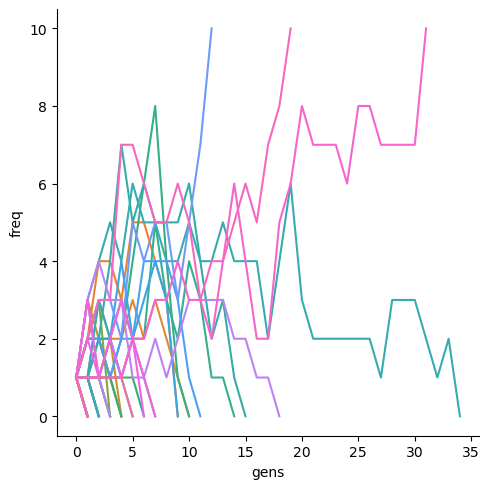

In [9]:
neu_trajectories= get_neutral_replicates(num_reps=50,Ne=10)
sns.relplot(x = "gens", y = "freq",hue="sim",kind = "line",data = neu_trajectories,legend=False)
plt.show()

### 6.1.2 Simulating selection **AND** drift

<div class="alert alert-block alert-info">
    <b>PopGen:</b> 

Suppose now that the *de novo* mutation confers a fitness advantage of $s$. In the WF model, carriers of the beneficial mutation leave on average a greater number of offspring, that is, reproduce at rate $(1 + s)$, while the remaining $N_e - 1$ individuals carrying the ancestral allele still give birth at rate $1$. The probability that any offspring inherits the new beneficial mutation is still binomially distributed, but now  $p = \frac{(1)(1 + s)}{(1)(1+s) + (N_e - 1)(1)}$. 

As for the neutral case above, when there are $ X > 1$ copies of the beneficial mutation, the probability observing $k$ copies in the next generation is binomially distributed with $p= \frac{X(1 + s)}{X(1 + s) + ( N_e  - X)( 1)}$.
    </div>

<div class="alert alert-block alert-success">    
    <b>Exercise 2:</b>
 <ul>
    <li> copy the code for running the neutral simulation below and modify it to include positive selection for simulating the frequency trajectory of a new beneficial mutation. The new function <code>sim_selection(i,Ne,s)</code> will take a third parameter for the strength of selection. </li>
        <li>check that it returns a data frame with the same formatting as above.</li>
        <li>once your selection simulations work, use the wrapper function <code>get_selection_replicates()</code> below to run 50 replicate simulations.</li>
        <li> plot the results.</li>
      </ul>
    </div>

In [10]:
## complete this function using the neutral simulation code to include positive selection in the simulation ##

def sim_selection(i,Ne,s):
    # i is any unique ID for the simulation. is converted to string. Usually pass an integer. 
    # N_e is the (haploid) population size 
    # s is is selection coefficient
    

sim_selection(i=1,Ne=50,s=0.1)

IndentationError: expected an indented block after function definition on line 2 (1340754496.py, line 8)

In [11]:
#SOL
def sim_selection(i,Ne,s):
    # i is any unique ID for the simulation. is converted to string. Usually pass an integer. 
    # N_e is the (haploid) population size 
    # s is is selection coefficient
    maxGens = 4000 #largest number of generations we will simulate
    
    bCount = Ne -1 #initial number of background allele
    BCount = 1 #initial freq of new beneficial mutation  
    traj = [] # will be populated by the frequency trajectory of ben mutation. 
    
    while True: #starts the simulation
        traj.append(BCount) #append current frequency to trajectory
        if(BCount >= Ne): 
            break
        if(BCount <= 0):  
            break
        if(len(traj)>maxGens):
            break
        
        # otherwise, we sample to make next generations
        pB = (BCount*(1 + s))/(BCount*(1 + s)+ bCount*(1)) #prob of sampling ben allele
        BCount = np.random.binomial(Ne,pB) # random number of ben mutations drawn 
                                            #from binomial distribution to produce next generations 
        bCount = Ne - BCount 
        
    # create and return a pandas data frame for the replicate smulation 
    gens = list(range(len(traj)))
    sim = [str(i) for _ in range(len(traj))]
    df = pd.DataFrame({"sim":sim,"gens":gens,"freq":traj})
    return(df)    

sim_selection(i=1,Ne=50,s=-0.1)

,sim,gens,freq
0,1,0,1
1,1,1,1
2,1,2,1
3,1,3,1
4,1,4,0


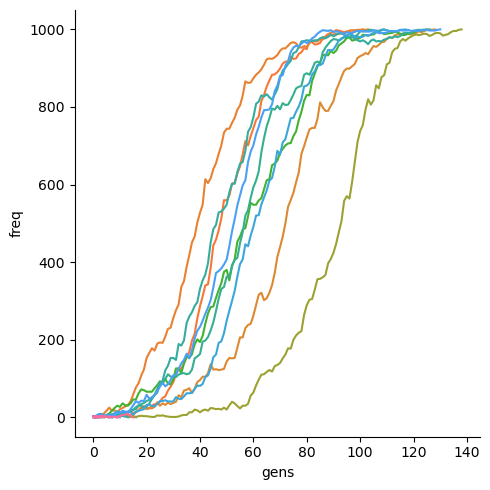

In [12]:
def get_selection_replicates(num_reps,Ne,sb):
    replicates = [sim_selection(i,Ne,sb) for i in range(num_reps)]
    trajectories = pd.concat(replicates,ignore_index=True)
    return(trajectories)

sel_trajectories= get_selection_replicates(num_reps=50,Ne=1000,sb=0.1)
sns.relplot(x = "gens", y = "freq",hue="sim",kind = "line",data = sel_trajectories,legend=False)
plt.show()

### 6.1.3 The effect of population size and selection strength on trajectories

Using the selection simulations you have implemented above, we can compare the fate of new mutations for different population sizes and strengths of selection. For each parameter combination, we plot 200 replicate trajectories of the new mutation.

We plot neutral simulations (first column) weak selection simulations (second column) and strong selection simulations (third column). Each row corresponds to a different population size (100, 1000, 10000), increasing from top to bottom.

For the selection scenarios, we also plot the expected deterministic allele frequency trajectory for a beneficial mutation (see lecture 5) using the function <code>calc_expected_traj</code> defined below:

In [13]:
def calc_expected_traj(Ne,sb):
    gensTotal = 10*Ne
    pB = 1
    traj = []
    for t in range(gensTotal):
        thisPB =  pB*math.exp(sb*t)/((pB*math.exp(sb*t) + Ne - 1))
        traj.append(thisPB)
        if thisPB >= (Ne-1)/(Ne):
            traj = np.array(traj)
            traj = traj*(Ne)
            return(traj)
            break
    traj = np.array(traj)
    traj = traj*(Ne)
    return(traj)

calc_expected_traj(10,0.2)

array([1.        , 1.19494632, 1.42189251, 1.68369876, 1.98256899,
       2.31969317, 2.69487452, 3.10619522, 3.54978923, 4.01979347,
       4.5085306 , 5.00693855, 5.50520865, 5.99354302, 6.46291022,
       6.90567858, 7.3160391 , 7.69018148, 8.02623937, 8.32405931,
       8.5848645 , 8.81088172, 9.00498468])

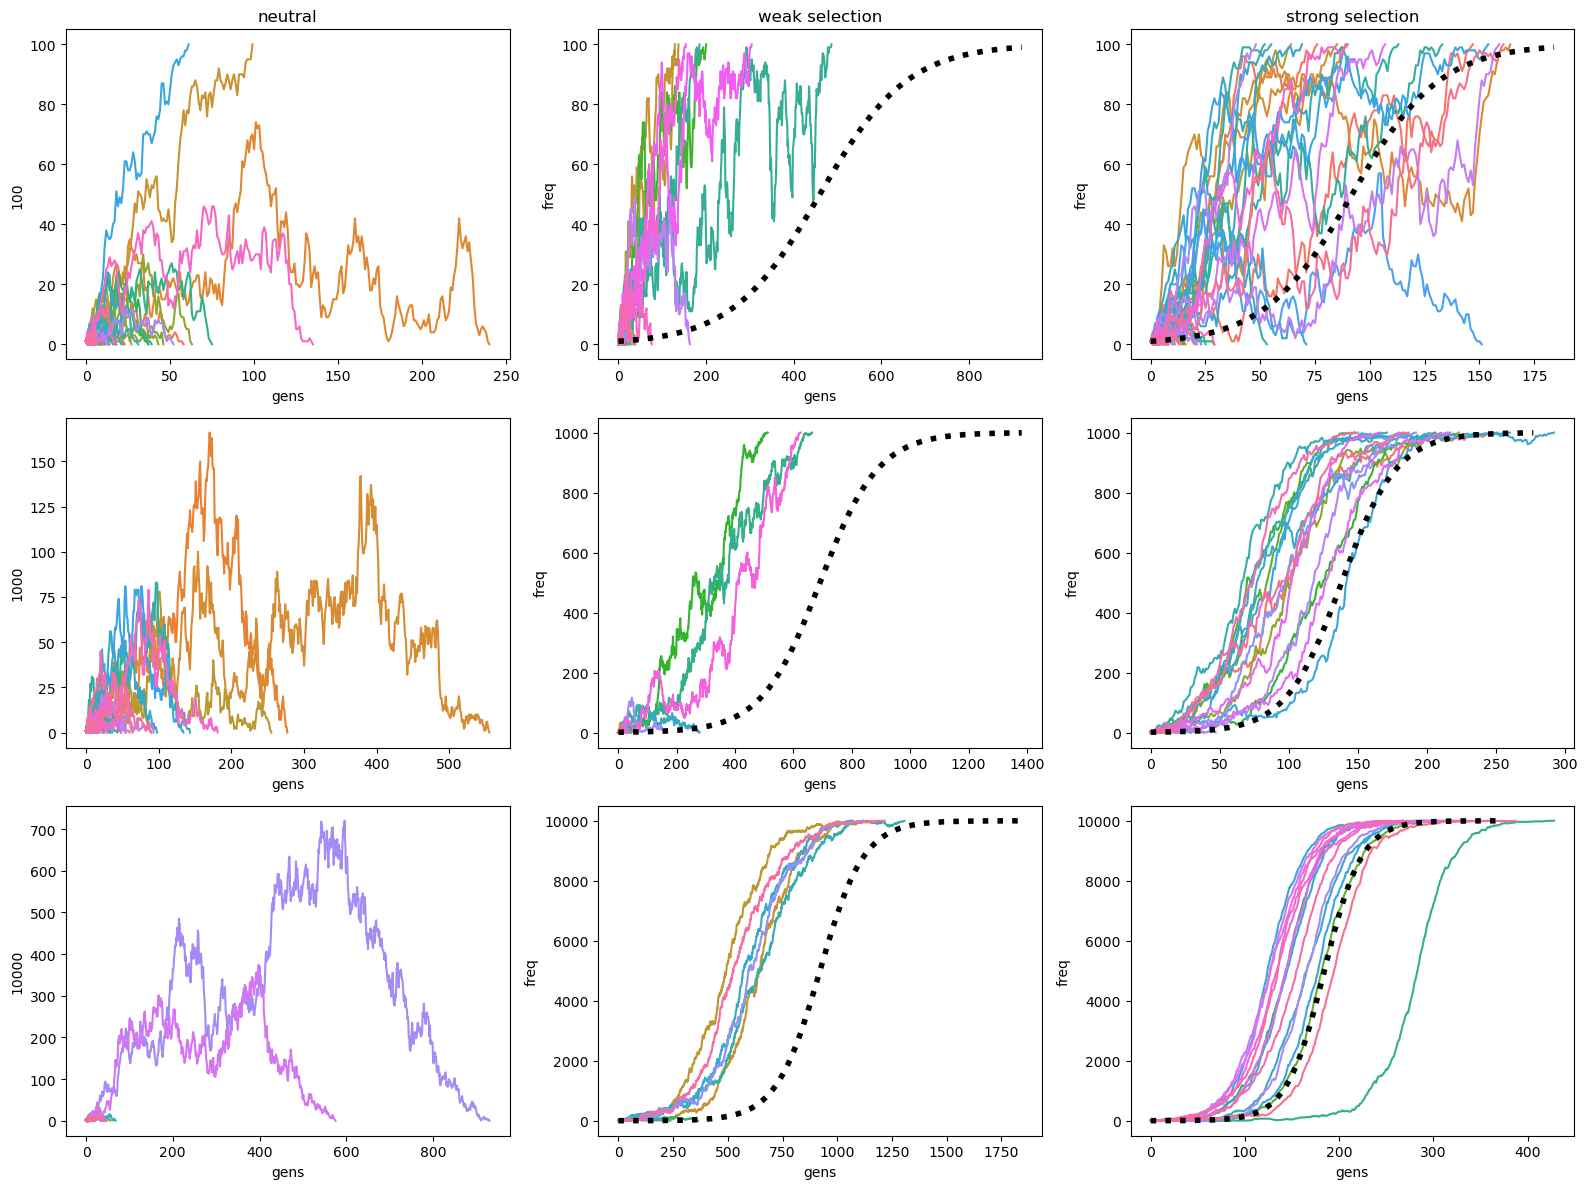

In [14]:
pop_sizes = [100,1000,10000]
sel_strengths = [0.01,0.05]
num_reps = 200

fig, axs = plt.subplots(3,3,figsize=(16,12))

for rowidx, Ne in enumerate(pop_sizes):
    trajectories = get_neutral_replicates(num_reps,Ne)
    sns.lineplot(x = "gens", y = "freq",hue="sim",data = trajectories,legend=False,ax = axs[rowidx,0])

for rowidx, Ne in enumerate(pop_sizes):
    for colidx,sb in enumerate(sel_strengths):
        trajectories = get_selection_replicates(num_reps,Ne,sb)
        sns.lineplot(x = "gens", y = "freq",hue="sim",data = trajectories,legend=False,ax = axs[rowidx,colidx +1])
        axs[rowidx,colidx+1].plot(calc_expected_traj(Ne,sb),":k",linewidth=4.0)
        
axs[0,0].set_title("neutral")
axs[0,1].set_title("weak selection")
axs[0,2].set_title("strong selection")

for ax,size in list(zip(axs[:,0],pop_sizes)):
    ax.set_ylabel(size)


fig.tight_layout()
plt.show()

<div class="alert alert-block alert-success">    
    <b>Exercise 3:</b> Execute the code cell above! 
     <ul>
    <li> How do trajectories differ for neutral vs. weak vs strong selection? How does this depend on pop size?</li> 
    <li> What is the fate of most new mutations, and why? Write down your conclusions.</li> 
    </ul
         
         
<b>Note:</b> the different scale of the x-axis (number of generations) in each plot.
    </div>

SOLUTION:
- across all scenarios, the new mutation tends to go extinct. Prob fix expected 1/(2Ne)
- a beneficial allele has a higher chance of reaching fixation, and this increases with the strength of selection (expected approximately $2 s_b$ in sufficiently large population)
- in small population, the trajectories of successful beneficial mutations are more variable
- in large populations, replicates that go to fixation vary in the total time to reach fixation but otherwise have similar shape as the deterministic model
- The ben allele reaches fixation much faster with stronger selection



<div class="alert alert-block alert-success">    
    <b>Class discussion:</b> 
    <ul>
    <li> How do trajectories differ when the allele frequency is low vs high? What dynamics of the model can explain these patterns?</li> 
    <li> How do sim trajectories differ from the expectation (dashed line above) and why?</li> 
        </ul>
    </div>

SOLUTION:

when the allele is very rare or very common, the frequency changes slowly, but at intermediate frequency, it goes quickly: the change in allele frequency $p$ is expected to be $p(1-p)s$.

SOLUTION:

the simulation trajectories reach high intermediate frequency and eventually fix more quickly than expected, but the shape of the trajectories at intermediate frequency matches expectation. The expected trajectory averages over all possible allele frequency changes, i.e. over all possible trajectories, including those in which the ben mutation is lost. However, the beneficial mutations which are lucky enough to reach fixation will tend to be those which by-chance get to high frequency quickly. Once at intermediate frequency, the allele is almost certain to fix, and the expected trajectory captures the dynamics of the underlying model accurately.

# 6.2 The effect of selection on linked neutral sites

Now that we have studied the direct effects of selection on the evolutionary trajectory of a new beneficial mutation, we want to investigate how fixation of an adaptive allele affects linked neutral sites in the genome.

Here we will use simulations in `msprime` to investigate the effect of positive selection on linked neutral variants.

### 6.2.0 Neutral Simulations


<div class="alert alert-block alert-warning">
    <b>Python refresher: simulating under the coalescent with <code>msprime</code> </b>  

Below, we simulate 50Mb of sequence assuming $N_e = 10,000$ (see <i>Homo</i> like sims in practical 3) under the standard neutral coalescent and plot the total branch length for each tree along the sequence.

In [3]:
#This specifies parameters we will use for our main  simulations of a neutral chromsome and a chromosome with a sweep

Ne = 10_000
L = 50e6
rbp = 2e-9
n=20
sb=0.05

#We are specifying a mutation rate, but will use branch-based statistics as much as possible (for efficiency):
mu = 1e-8 
#We are setting up an empty data frame which we will fill as we go along:
divdf = pd.DataFrame() 

In [4]:
#This sets up a single neutral simulation given the parameters above: 
ts_neutral = msprime.sim_ancestry(
    samples=n,
    model=[msprime.StandardCoalescent()],
    population_size=Ne,
    recombination_rate=rbp,
    sequence_length=L
    #,
    #random_seed=seed_neu
)

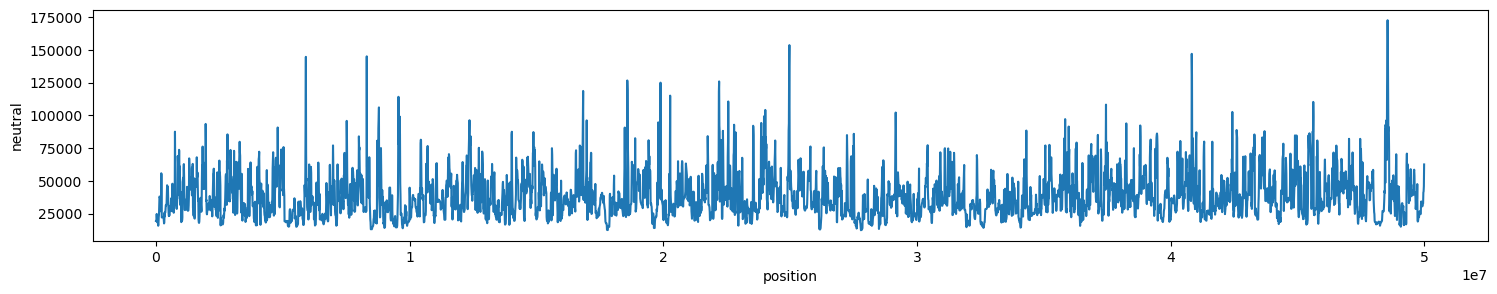

In [5]:
#Making windows of 10kb 
winStartPositions = np.arange(0,L,10_000)
slidingWindows=np.append(winStartPositions,L)

divdf["position"]=winStartPositions
#computing diversity in windows
div_neu = ts_neutral.diversity(windows=slidingWindows, mode='branch')
divdf["neutral"]=div_neu

fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(data =divdf, x="position",y="neutral")
plt.show()

### 6.2.1 The effect of selection on genetic diversity

<div class="alert alert-block alert-success">    
    <b>Exercise 4 - msprime simulation for positive selection:</b> Modify the code below to implement a sweep model. Calculate diversity in windows, add this to the data frame "divdf" as a new column called "sweep", and produce a scatter plot (as above). For the sweep model: Place the beneficial mutation at the center of the chromosome. For the initial frequency, assume that the beneficial allele is a <i>de novo</i> mutation. For the final frequency, stop the sweep when there is only one copy of the ancestral mutation remaining.
    
<b>Hints: </b> Check out the msprime documentation of [<code>SweepGenicSelection</code>](https://tskit.dev/msprime/docs/latest/api.html#msprime.SweepGenicSelection) to:
<ul>
    <li> Define a positive selection model placing the beneficial mutation at the center of the chromosome.</li> 
    <li> Combine the selection phase with a neutral coalescent to simulate selective sweep.</li>
    <li> Compute and plot genetic diversity in sliding windows as before.</li>
    </ul>
    </div>

In [58]:
## Insert parameter values for the position, start and end frequency, and strength of selection in the code below to define the 
# sweepGenicSelection model. The appropriate parameter values are defined at the start of section 6.2.0

sweepModel = msprime.SweepGenicSelection(
    position =   , #ben mutation at the centre
    start_frequency=   ,# initial freq of de-novo mutation
    end_frequency=    ,#final frequency of de-novo ben mutation
    s=     ,#strength of selection
    dt = 1/(40*Ne)
)

SyntaxError: expected argument value expression (2284360907.py, line 5)

In [59]:
## define the correct ancestry model below
ts_sel = msprime.sim_ancestry(
    samples=n,
    model=    , #simulate the sweep first, followed by standard coal
    population_size=Ne,
    recombination_rate=rbp,
    sequence_length=L
)
print(ts_sel.num_trees)

SyntaxError: expected argument value expression (1878474332.py, line 4)

In [8]:
#Plot genetic diversity




13115


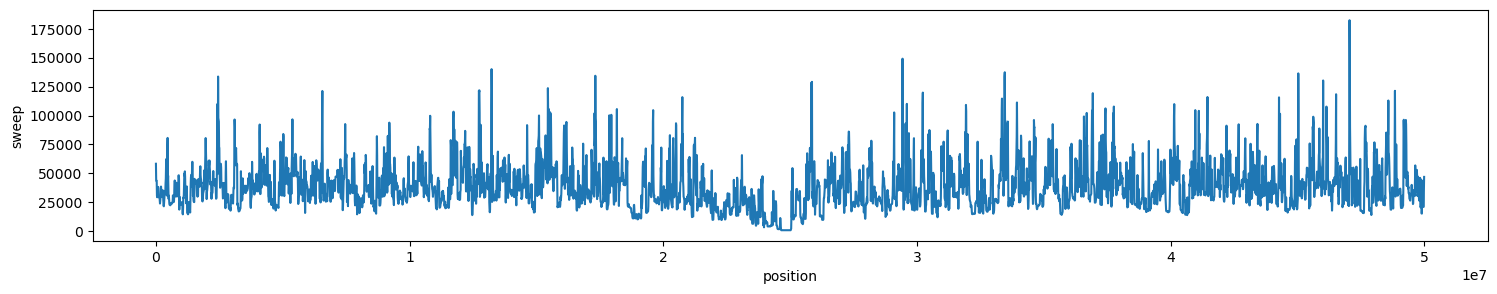

In [31]:
####  SOLUTION:

## Correctly add sweep parameters in:
sweepModel = msprime.SweepGenicSelection(
    position = L/2, 
    #ben mutation at the centre
    start_frequency=1/(2*Ne), #initial freq of de-novo mutation
    end_frequency= 1 - 1/(2*Ne), #final frequency of de-novo ben mutation
    s=sb,
    dt = 1/(40*Ne)
)

## define the correct ancestry model:
ts_sel = msprime.sim_ancestry(
    samples=n,
    model=[sweepModel,msprime.StandardCoalescent()], #simulate the sweep first, followed by standard coal
    population_size=Ne,
    recombination_rate=rbp,
    sequence_length=L
    #,
    #random_seed=seed_sel
)
print(ts_sel.num_trees)

# Plot diversity in windows
div_sel = ts_sel.diversity(windows=slidingWindows,mode='branch')
divdf["sweep"] = div_sel

fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(data =divdf, x="position",y="sweep")
plt.show()


<div class="alert alert-block alert-success">    
    <b>Exercise 5:</b> How does selection affect the distribution of window-wise genetic diversity compared to the neutral distribution?

<b> Hint:</b> Use <code>sns.histplot</code> to plot both distributions.
    </div>

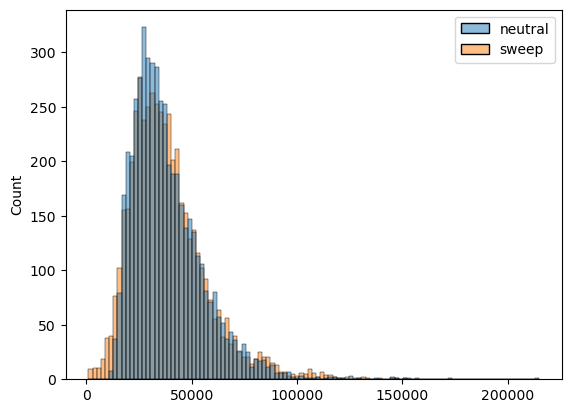

In [10]:
#SOLUTION:

p = sns.histplot(data=divdf[["neutral","sweep"]])

#increased number of low-diversity windows in sweep simulation

### 6.2.2 The effect of selective sweeps on the SFS

We will consider a smaller sample of $n=5$ (diploid) individuals, a shorter length of sequence (4Mb) to investigate the effect of sweeps on the SFS at nearby neutral sites. As in practical 2 we will compute the expected SFS by averaging across replicates (in this case 500).

In [60]:
# # this defines a few local parameters for use in this section
popSize = 10_000
benStrength = 0.05
chrLength = 4e6
recRate = 1e-9
sampleSize = 5 #diploids
numReplicates = 500
numWindows=4
winBreaks = [chrLength/numWindows*i for i in range(0,numWindows+1)]

<div class="alert alert-block alert-info">
<b>PopGen reminder: the SFS</b>
    
You have already enountered the analytic predictions for the SFS for a sample from a neutral WF population in practical 2. Given a sequence with a scaled mutation rate $\theta$, the SFS (in terms of the expected number of iton mutations) is $S_i = \theta/i$ for $i = 1,2,...,n-1$. See lecture 2.
    </div>

The code chunk below obtains the expected neutral SFS for polarized `neutSFSUnfolded` and non-polarized data `neutSFSFolded` for a sample of $n$ individuals:

In [61]:
nHaplotypes = 2*sampleSize
neutExp = np.array([1/i for i in range(1,2*sampleSize)])
neutSFSUnfolded = neutExp
neutSFSUnfolded /= neutSFSUnfolded.sum()

<div class="alert alert-block alert-success">    
    <b>Exercise 6:</b> 
    <ul>
    <li>use the unfolded SFS (<code>neutSFSUnfolded</code>, above) to derive the folded site frequency spectrum and save it as <code>neutSFSFolded</code> </li>

        
Hint: you can reverse the order of an array using np.flip(arr)
        
Check that  <code>neutSFSFolded</code> sums to 1. You do not need to normalize it.      
    </ul>
</div>

In [62]:
#Sol, one option:

flipped = np.flip(neutSFSUnfolded)
idx = 0
neutSFSFolded = []
while idx<nHaplotypes/2:
    if idx == nHaplotypes/2 -1:
        neutSFSFolded.append(neutSFSUnfolded[idx]) # we only want to count this entry once
    else: 
        neutSFSFolded.append(neutSFSUnfolded[idx] + flipped[idx]) # otherwise, we sum them to get the folded counts
    idx +=1
print(neutSFSFolded)
print(sum(neutSFSFolded))

[np.float64(0.3927619581989059), np.float64(0.22092860148688456), np.float64(0.1683265535138168), np.float64(0.14728573432458972), np.float64(0.07069715247580306)]
1.0


Let's investigate the effect of sweeps on the SFS at linked neutral sites. The code chunk below runs 500 replicate sweep simulations, assuming a single beneficial allele at `position = 1`
- for each replicate, we get the SFS in 1Mb windows (non-overlapping) increasingly far from the center of the sweep, both for the folded and unfolded SFS
- for each distance, we average the SFS across replicates.


<div class="alert alert-block alert-success">    
    <b>Exercise 7:</b> 
    Execute the code cell below.  It will plot the SFS for four windows at increasing distance from the sweep center as well as the corresponding site frequency spectrum. 

- what affect does the sweep have on the folded SFS?
- how does this comopare to the unfolded SFS?
- Does polarising the data provide more information?
    


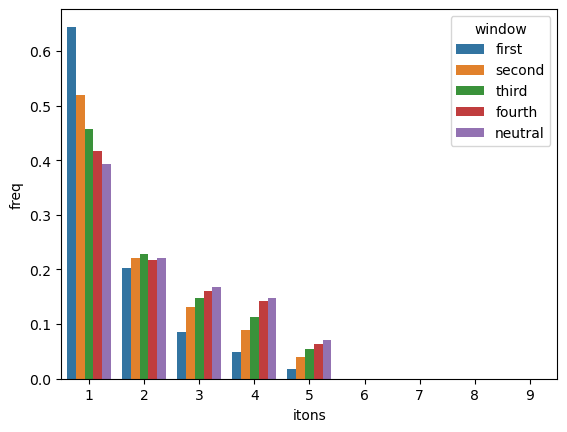

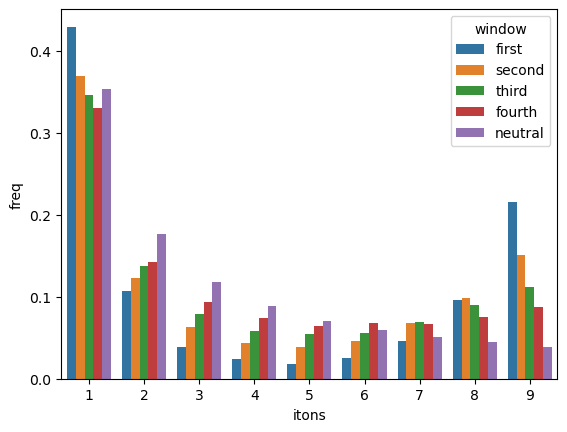

In [63]:

nHaplotypes = 2*sampleSize
neutExp = np.array([1/i for i in range(1,2*sampleSize)])
neutSFSUnfolded = neutExp
neutSFSUnfolded /= neutSFSUnfolded.sum()

flipped = np.flip(neutExp)
idx = 0
neutSFSFolded = []
while idx<nHaplotypes/2:
    if idx == nHaplotypes/2 -1:
        neutSFSFolded.append(neutSFSUnfolded[idx]) # we only want to count this entry once
    else: 
        neutSFSFolded.append(neutSFSUnfolded[idx] + flipped[idx]) # otherwise, we sum them to get the folded counts
    idx +=1



sweepModel = msprime.SweepGenicSelection(
    position = 1,
    start_frequency=1.0/(2*popSize),
    end_frequency= 1 - 1.0/(2*popSize),
    s=benStrength,
    dt = 1/(40*popSize)
)

replicates = msprime.sim_ancestry(
    samples=sampleSize,
    model=[sweepModel,msprime.StandardCoalescent()],
    population_size=popSize,
    recombination_rate=recRate,
    sequence_length=chrLength,
    num_replicates = numReplicates
)

sfs_rep_table_folded = np.zeros((numReplicates,numWindows,2*sampleSize+1))
sfs_rep_table_unfolded = np.zeros((numReplicates,numWindows,2*sampleSize+1))
for replicate_index, ts in enumerate(replicates):
    sfsUnfolded = ts.allele_frequency_spectrum(mode = "branch",polarised = True,windows=winBreaks)
    sfsFolded = ts.allele_frequency_spectrum(mode = "branch",polarised = False,windows=winBreaks)
    sfs_rep_table_folded[replicate_index] = sfsFolded
    sfs_rep_table_unfolded[replicate_index] = sfsUnfolded

#win_sfs_table: each row is the SFS for a window of 1Mb increasingly far from the sweep centre.
win_sfs_table_folded = np.apply_along_axis(np.mean,0,sfs_rep_table_folded)
win_sfs_table_folded = np.apply_along_axis(lambda x: x/sum(x),1,win_sfs_table_folded)
win_sfs_table_folded = np.apply_along_axis(lambda x: x[1:-1],1,win_sfs_table_folded)
#print(win_sfs_table_folded)

#win_sfs_table: each row is the SFS for a window of 1Mb increasingly far from the sweep centre.
win_sfs_table_unfolded = np.apply_along_axis(np.mean,0,sfs_rep_table_unfolded)
win_sfs_table_unfolded = np.apply_along_axis(lambda x: x/sum(x),1,win_sfs_table_unfolded)
win_sfs_table_unfolded = np.apply_along_axis(lambda x: x[1:-1],1,win_sfs_table_unfolded)
#print(win_sfs_table_unfolded)


##dataframe and plot for folded
iTons = list(range(1,10))
windows = ['first','second','third','fourth']
dfWST_folded = pd.DataFrame()
for name,vals in list(zip(windows,win_sfs_table_folded)):
# This creates a temporary dataframe for each distance from the sweep 
    tempdf = pd.DataFrame({'itons':iTons,'freq':vals,'window':[name]*(2*sampleSize-1)})
    dfWST_folded= pd.concat([dfWST_folded,tempdf])

nSFS_folded = np.zeros(len(neutSFSUnfolded)) #add zero entries to unfolded SFS for plotting and store as "a"
for idx, val in enumerate(neutSFSFolded):
    nSFS_folded[idx]=val
dfNeut_folded = pd.DataFrame({'itons':iTons,'freq':nSFS_folded,'window':['neutral']*(2*sampleSize-1)})

dfWST_folded = pd.concat([dfWST_folded,dfNeut_folded])

pFolded = sns.barplot(x="itons",y="freq",hue="window",data=dfWST_folded)
plt.show()


##dataframe and plot for unfolded
iTons = list(range(1,10))
windows = ['first','second','third','fourth']
dfWST_unfolded = pd.DataFrame()
for name,vals in list(zip(windows,win_sfs_table_unfolded)):
# This creates a temporary dataframe for each distance from the sweep 
    tempdf = pd.DataFrame({'itons':iTons,'freq':vals,'window':[name]*(2*sampleSize-1)})
    dfWST_unfolded= pd.concat([dfWST_unfolded,tempdf])

nSFS_unfolded = np.zeros(len(neutSFSUnfolded)) #add zero entries to unfolded SFS for plotting and store as "a"
for idx, val in enumerate(neutSFSUnfolded):
    nSFS_unfolded[idx]=val
dfNeut_unfolded = pd.DataFrame({'itons':iTons,'freq':nSFS_unfolded,'window':['neutral']*(2*sampleSize-1)})

dfWST_unfolded = pd.concat([dfWST_unfolded,dfNeut_unfolded])

pUnfolded = sns.barplot(x="itons",y="freq",hue="window",data=dfWST_unfolded)
plt.show()

SOLUTION:

For the folded SFS, the sweep increases the proportion of variable sites carryigng low frequency mutations (i.e. singletons) and reduces the abundance of intermediate frequency polymorphisms. In this example, the SFS from the window 4 MB away from the beneficial mutation is not very different from the neutral SFS

For the unfolded SFS, we see that the sweep only slightly increases the proportion of singletons, rather inflating the abundance of high-frequency polymorphisms. This key signature of a selective sweep is lost when we use the folded SFS.  We also see that there is still a clear signature of selection even for the window 4Mb from the beneficial mutation.

# 6.3 Genomic scans for adaptive evolution using SweepFinder


## 6.3.0 Sweepfinder Background information

Here we will perform scans for selection using SweepFinder using the `ts_neutral` and `ts_sel` simulations obtained in **5.2.2** above (the ones with long chromosomes, $n=20$ and the beneficial mutation in the middle). Details of the method are found [Nielsen et al 2005](https://genome.cshlp.org/content/15/11/1566). We first learn to format the data correctly for use in SweepFinder and then think about how to interpret the results.


We have re-implemented the sweepfinder approach in python for use in this tutorial.

The two main ingredients we need are the mutation positions and counts as well as the site frequency spectrum.
The site frequency spectrum can be given separately or it can be calculated from the list of mutation counts


For now, we will restrict ourselves to variable sites that are covered across all individuals.  
This is always true for the simulations, but we will need to be careful about this with the real data.

Our version of  SweepFinder takes as input:

    - a list of test sites
    - the (haploid) number of samples n
    - a list of mutations with frequencies 1 < x < n
    - the positions of these mutations
    - the neutral (background) SFS for x = [ 0, 1, ..., (n-1), n] mutations. we assume monormphic sites are absent, i.e. x[0].
    - whether the sfs is folded 
    - whether fixed differences (to the outgroup used for polarising) are included



SweepFinder returns a pandas data frame with columns corresponding to:

    - position: location of the test site
    - lnCL: the log likelihood for the best-fitting sweep model
    - alpha: the relative strength of selection for the best-fitting sweep model
    - log10 alpha:  (-1)*Log10(alpha)  for visualizing better, so higher values correspond to stronger selection
    - lnCL diff:  the difference in log likelihood between the best-fitting sweep model and the neutral background model


## 6.3.1 Sweep scans on simulations


### 6.3.1.1 The neutral background SFS and Mutation Counts

Below, We use the neutral simulation ts_neutral to obtain the background sitefrequency spectrum, here using branched statistics.

Note that the SFS includes entries for mutations with counts i=0,1,2,...,n.  i=0 corresponds to monomorphic sites and should always have frequency 0. 

For the unfolded SFS, i=n may be non-zero if fixed-differences from an outgroup are included (here, theya re not). 

The folded SFS has frequencies of 0.0 for all 'major' allele counts.

In [64]:
backgroundSFSFolded = ts_neutral.allele_frequency_spectrum(mode='branch',polarised=False)
backgroundSFSFolded = backgroundSFSFolded/sum(backgroundSFSFolded)
print('folded')
print(backgroundSFSFolded)

backgroundSFSUnfolded = ts_neutral.allele_frequency_spectrum(mode='branch',polarised=True)
backgroundSFSUnfolded = backgroundSFSUnfolded/sum(backgroundSFSUnfolded)
print('unfolded')
print(backgroundSFSUnfolded)


folded
[0.         0.24661624 0.12074636 0.08591157 0.06486293 0.05157939
 0.044639   0.03882274 0.0366928  0.03353694 0.03243204 0.02888462
 0.02781153 0.03003062 0.02782029 0.02313823 0.02604665 0.02340466
 0.02109858 0.02344826 0.01247658 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
unfolded
[0.         0.24012426 0.11615723 0.080124   0.05906099 0.04583293
 0.03841677 0.03295705 0.02988094 0.02650414 0.02441008 0.0210603
 0.02016382 0.02084465 0.01859613 0.01431356 0.01536593 0.01398818
 0.01201419 0.01283465 0.01247658 0.01061361 0.00908439 0.00941648
 0.01068072 0.00882467 0.00922415 0.00918597 0.00764771 0.00782431
 0.00802195 0.0070328  0.00681186 0.00586569 0.00622223 0.00574645
 0.00580194 0.00578757 0.00458913 0.00649198 0.        ]


So far, we have used branch-based statistics provided by msprime/tskit. However, when running sweepfinder scans on population genomic data (simulated or real), we can only work with polymorphisms.

Below, we add mutations to bot the _neutral_ and _selection_ simulations, obtain mutation counts along the genome, both for a polarised and nonpolarised data set, and format this as an input table for SweepFinder.

In [65]:
mts_neutral = msprime.sim_mutations(ts_neutral, rate=mu)
print("theta per base= ", 4*Ne*mu)
print("observed num mutations:", mts_neutral.num_mutations)
print("expected num mutations",mu*4*Ne*L* sum([1/i for i in range(1,2*n)])) #expected number


biallelicSNPsNeutralFolded =  [[int(var.site.position), min([sum(var.genotypes),2*n - sum(var.genotypes)]),2*n,1] for var in mts_neutral.variants() if len(var.alleles)==2]
biallelicSNPsNeutralFolded = pd.DataFrame(biallelicSNPsNeutralFolded,columns=['position','x','n','folded'])
biallelicSNPsNeutralFolded = biallelicSNPsNeutralFolded[biallelicSNPsNeutralFolded["x"]>0]
biallelicSNPsNeutralFolded = biallelicSNPsNeutralFolded[biallelicSNPsNeutralFolded["x"]<40]


biallelicSNPsNeutralUnfolded =  [[int(var.site.position), sum(var.genotypes),2*n,0] for var in mts_neutral.variants() if len(var.alleles)==2]
biallelicSNPsNeutralUnfolded = pd.DataFrame(biallelicSNPsNeutralUnfolded,columns=['position','x','n','folded'])
biallelicSNPsNeutralUnfolded = biallelicSNPsNeutralUnfolded[biallelicSNPsNeutralUnfolded["x"]>0]
biallelicSNPsNeutralUnfolded = biallelicSNPsNeutralUnfolded[biallelicSNPsNeutralUnfolded["x"]<40]

biallelicSNPsNeutralUnfolded[:5]

theta per base=  0.0004
observed num mutations: 82062
expected num mutations 28588.418360889435


,position,x,n,folded
0,639,1,40,0
1,2839,1,40,0
2,4280,1,40,0
3,5544,13,40,0
4,6159,13,40,0


In [66]:
mts_sel = msprime.sim_mutations(ts_sel, rate=mu)
print("theta per base= ", 4*Ne*mu)
print("observed num mutations:", mts_sel.num_mutations)
print("expected num mutations",mu*4*Ne*L* sum([1/i for i in range(1,2*n)])) #expected number


biallelicSNPsSweepFolded =  [[int(var.site.position), min([sum(var.genotypes),2*n - sum(var.genotypes)]),2*n,1] for var in mts_sel.variants() if len(var.alleles)==2]
biallelicSNPsSweepFolded = pd.DataFrame(biallelicSNPsSweepFolded,columns=['position','x','n','folded'])
biallelicSNPsSweepFolded = biallelicSNPsSweepFolded[biallelicSNPsSweepFolded["x"]>0]
biallelicSNPsSweepFolded = biallelicSNPsSweepFolded[biallelicSNPsSweepFolded["x"]<40]

biallelicSNPsSweepFolded[0:5]

biallelicSNPsSweepUnfolded =  [[int(var.site.position), sum(var.genotypes),2*n,0] for var in mts_sel.variants() if len(var.alleles)==2]
biallelicSNPsSweepUnfolded = pd.DataFrame(biallelicSNPsSweepUnfolded,columns=['position','x','n','folded'])
biallelicSNPsSweepUnfolded = biallelicSNPsSweepUnfolded[biallelicSNPsSweepUnfolded["x"]>0]
biallelicSNPsSweepUnfolded = biallelicSNPsSweepUnfolded[biallelicSNPsSweepUnfolded["x"]<40]


biallelicSNPsSweepUnfolded[:5]

theta per base=  0.0004
observed num mutations: 79430
expected num mutations 28588.418360889435


,position,x,n,folded
0,48,5,40,0
1,448,2,40,0
2,598,1,40,0
3,988,2,40,0
4,1380,5,40,0


<div class="alert alert-block alert-success">    
    <b>Exercise 8:</b> Check the output above. How does the total number of mutations ($S$) differ between the neutral and the sweep simulation? How close are either to the analytic expectation $E[S]$ under neutrality?
    </div>

SOL:
- the observed number of mutations is lower than expected for the selective sweep simulations 
- the hitchhiking of mutations at sites linked to the beneficial mutation results in fixation 
- of one allele and loss of the other

### 6.3.1.2 Running sweepfinder on simulation data

Here, we will run a scan on the simulation data with the selective sweep using the __unfolded__ SFS.

We already have the neutral background site frequency spectrum and mutation frequencies obtained above.

Here, we define all the variables we pass to our version of sweepfinder:

In [68]:
mutPositions = np.array(biallelicSNPsSweepUnfolded["position"])
mutFreqs = np.array(biallelicSNPsSweepUnfolded["x"])

L = 50e6
nSamples = 40
foldedBool = False
fixedDiffBool = False

testSites = np.arange(1,L,100_000)
print(len(testSites))



500


**note** to avoid errors, reload the sweepfinder module each time before running the scan, as follows:

In [69]:
from importlib import reload
reload(sf)

start = time.time()
resultsSimUnfolded = sf.run_sweepfinder(testSites,nSamples,mutFreqs,mutPositions,backgroundSFSUnfolded,foldedBool,fixedDiffBool)
print(f"time it took: {time.time()-start}")
resultsSimUnfolded

time it took: 10.458198308944702


,position,lnCL,alpha,log10 alpha,lnCL diff
0,1.0,-244961.649995,0.010000,2.000000,-0.091856
1,100001.0,-244961.594202,0.010000,2.000000,-0.036062
2,200001.0,-244959.191158,0.000274,3.563043,2.366982
3,300001.0,-244960.827494,0.000762,3.118330,0.730646
4,400001.0,-244960.919622,0.002890,2.539177,0.638518
...,...,...,...,...,...
495,49500001.0,-244921.349959,0.001082,2.965973,40.208181
496,49600001.0,-244921.448077,0.010000,2.000000,40.110063
497,49700001.0,-244921.514966,0.010000,2.000000,40.043174
498,49800001.0,-244921.629938,0.000598,3.223662,39.928202


<div class="alert alert-block alert-info">
    <b>PopGen: Estimating $s$ from SweepFinder's $\alpha$ </b>
    
$\alpha$ is a measure of the rate of recombination relative to the effective strength of selection in the population.  $\alpha = r/s* Log( 2 N_e)$. If we have an estimate of $r$ and $N_e$ (or know them, as in these simulations) we can convert this estimate of $\alpha$ to an estimate of $s$, the fitness effect of the beneficial mutation.

**note** the $s$ in this equation corresponds to the strength of selection in *heterozygous* individuals under co-dominance. In contrast, for msprime, we provided the strength of selection on the beneficial mutation in the *homozygous* state. 
    
</div>

<div class="alert alert-block alert-success">    
    <b>Exercise 9:</b> For the selection scans, use the formula above to calculate the strength of selection from the estimated 'Alpha' values and add this information as a new column <code>sb</code> in the respective data frames. We will use this to plot the results below.
    
<b>Hint</b>: Use <code>math.log(x)</code> to calculate the natural logarithm of "x".
    </div>



In [70]:
### solution: Function is defined, then we add that info to the dataframe. 
def get_sb_from_alpha(alpha,Ne,rbp):
    s = math.log(2*Ne)/alpha * rbp
    return s

In [71]:
sbArray = np.zeros(len(resultsSimUnfolded["alpha"]))
for idx,alpha in enumerate(resultsSimUnfolded["alpha"]):
    sbArray[idx] = get_sb_from_alpha(alpha,Ne,rbp)
resultsSimUnfolded["sb"] = sbArray

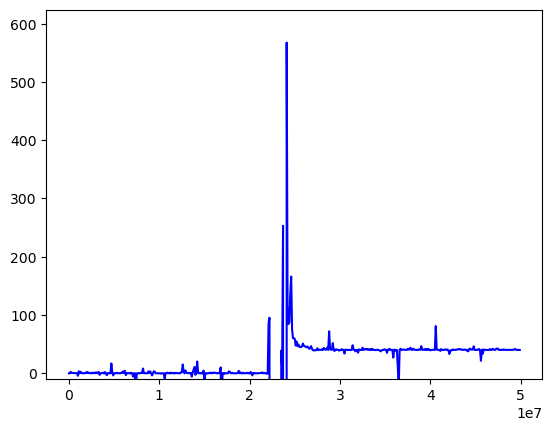

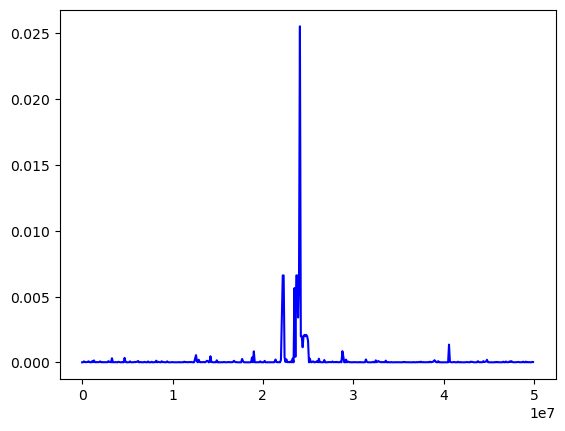

position       2.410000e+07
lnCL          -2.443942e+05
alpha          7.758789e-07
log10 alpha    6.110206e+00
lnCL diff      5.673984e+02
sb             2.552844e-02
Name: 241, dtype: float64


In [72]:
plt.plot(resultsSimUnfolded["position"],resultsSimUnfolded["lnCL diff"],color='b')
plt.ylim(-10,max(resultsSimUnfolded["lnCL diff"]*1.1))
plt.show()

plt.plot(resultsSimUnfolded["position"],resultsSimUnfolded["sb"],color='b')
plt.show()

mostLikelyIdx = resultsSimUnfolded["lnCL diff"].idxmax()
print(resultsSimUnfolded.iloc[mostLikelyIdx])

<div class="alert alert-block alert-success">    
    <b>Exercise 10:</b> Sweep scan using the <b>folded</b> SFS
    
Reload the sweepfinder module, and modify the code above to run the scan but this time using the folded neutral SFS and the folded mutation counts from the sweep simulation.
    
save the resulting data frame as "resultsSimFolded"
    
plot the results alongside those for the unfolded site frequency spectrum (that we saved as "resultsSimUnfolded" above)

Where is the most likely position for the center of the sweep?  How do these results compare to those from the unfolded SFS?

500
time it took: 9.694385051727295


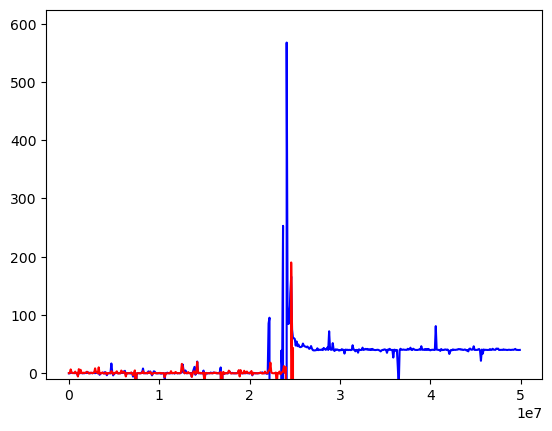

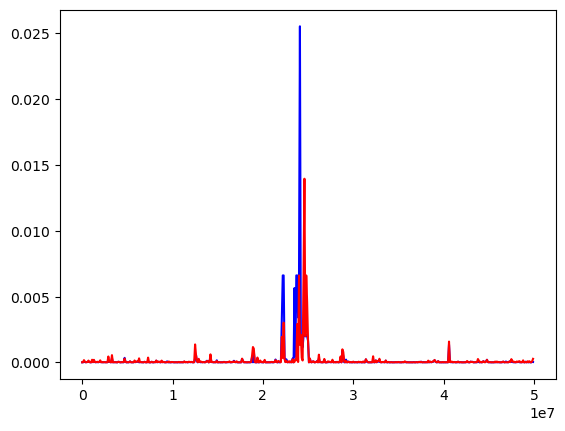

position       2.460000e+07
lnCL          -2.143522e+05
alpha          1.419922e-06
log10 alpha    5.847736e+00
lnCL diff      1.901373e+02
sb             1.394934e-02
Name: 246, dtype: float64


In [73]:
# Solution:

mutPositions = np.array(biallelicSNPsSweepFolded["position"])
mutFreqs = np.array(biallelicSNPsSweepFolded["x"])

L = 50e6
nSamples = 40
foldedBool = True
fixedDiffBool = False

testSites = np.arange(1,L,100_000)
print(len(testSites))


from importlib import reload
reload(sf)

start = time.time()
resultsSimFolded = sf.run_sweepfinder(testSites,nSamples,mutFreqs,mutPositions,backgroundSFSFolded,foldedBool,fixedDiffBool)
print(f"time it took: {time.time()-start}")

resultsSimFolded["sb"] = resultsSimFolded['alpha'].apply(lambda x: math.log(2*Ne)/x*rbp)


plt.plot(resultsSimUnfolded["position"],resultsSimUnfolded["lnCL diff"],color='b')
plt.plot(resultsSimFolded["position"],resultsSimFolded["lnCL diff"],color='r')

yMaxVal = max(max(resultsSimUnfolded["lnCL diff"]),max(resultsSimFolded["lnCL diff"]))
plt.ylim(-10,max(resultsSimUnfolded["lnCL diff"]*1.1))
plt.show()

plt.plot(resultsSimUnfolded["position"],resultsSimUnfolded["sb"],color='b')
plt.plot(resultsSimFolded["position"],resultsSimFolded["sb"],color='r')
plt.show()

# plt.plot(resultsSimUnfolded["position"],resultsSimUnfolded["log10 alpha"],color='b')
# plt.plot(resultsSimFolded["position"],resultsSimFolded["log10 alpha"],color='r')
# plt.show()

mostLikelyIdx = resultsSimFolded["lnCL diff"].idxmax()
print(resultsSimFolded.iloc[mostLikelyIdx])


# 6.4 Signatures of selection in _Heliconius_ butterflies


Let's look at a SweepFinder scan on a real data set! We will first import a vcf file containing variation data from several individuals of *Heliconius* butterflies belonging to different closely related species and mimicry races. These data were obtained by mapping WGS Illumina reads against the *Heliconius melpomene* reference genome and are from [(Martin et al 2020)](https://datadryad.org/stash/dataset/doi:10.5061/dryad.sk2pd88).

You will analyze this data set much more closely in practical 6. For simplicity, we focus on chromosome 18 and restrict our analysis to 10 individuals from a single sub-species: _H. melpomene malleti_.

### 6.4.1 Importing and Subsetting the _Heliconius_ data

The cell below imports the variant data from the vcf file and and subsets it using scikit allel.

In [42]:
## import the vcf file retaining the genotype calls, variant positions, and sample names
samples_mal = ['mal.CS1002', 'mal.CS1011', 'mal.CS1815', 'mal.CS21', 'mal.CS22', 'mal.CS24', 'mal.CS586', 'mal.CS594', 'mal.CS604', 'mal.CS615']
gt_key, pos_key, sample_key = 'calldata/GT', 'variants/POS', 'samples'
vcf_f ='p5_data_2024/heli_chrom18.vcf.gz'
helidata = allel.read_vcf(vcf_f, fields=[gt_key, pos_key, sample_key], samples=samples_mal)
L = 16802709
nSamples = 10*2

As in the last practical, we store the variant positions and the genotypes as separate arrays and turn the genotype array into an array of allele counts:

In [43]:
positions = helidata['variants/POS']
heliGTs = allel.GenotypeArray(helidata['calldata/GT']);

mal_counts = heliGTs.count_alleles()
mal_counts

<AlleleCountsArray shape=(1441823, 3) dtype=int32>
18  0  0
17  1  0
15  3  0
...
20  0  0
12  8  0
10 10  0

<div class="alert alert-block alert-success">    
    <b>Exercise 11:</b>
    The data from this VCF file only contain polymorphic sites, so why does the first entry only have a single allele? Use scikit allel's <code>is_biallelic()</code> function to restrict the counts and position arrays to biallelic sites (see practical 4). Store the new counts and positions as <code>ba_mal_counts</code> and <code>ba_positions</code> (check how many sits are filtered out).
</div>

In [44]:
#SOL
# sites that are polymorphic in the full data set may be monomorphic within our subset of the data.
boolBiallelic = mal_counts.is_biallelic()
ba_mal_counts = mal_counts[boolBiallelic]
ba_positions = positions[boolBiallelic]

We now use the <code>allel.windowed_diversity()</code> method (see pratical 4, exercise 8) to plot genetic diversity along the chromosome in windows of 100_000 bases

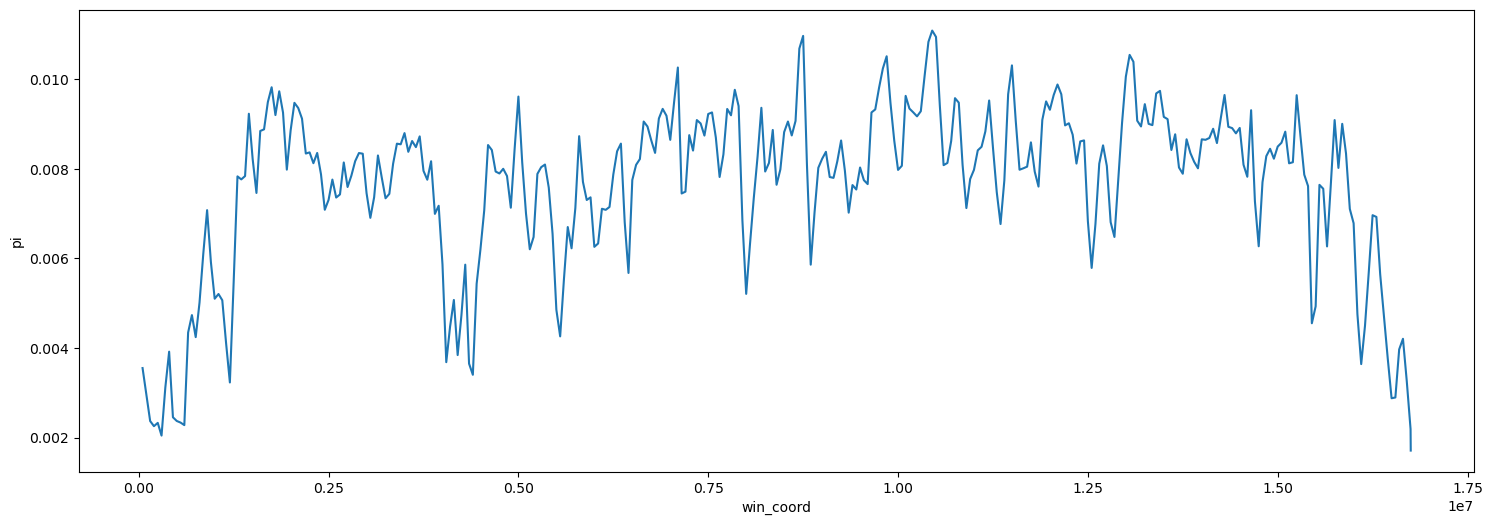

In [45]:

window_size = 100_000
pi, windows, bases, counts = allel.windowed_diversity(ba_positions, ba_mal_counts, size=window_size, start=0, stop=ba_positions[-1], step=int(window_size/2))
win_coord = windows[:,1] - (window_size / 2)
win_pi_df = pd.DataFrame({'win_coord':win_coord,'pi':pi})
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(x='win_coord', y='pi', data = win_pi_df)
plt.show()

<div class="alert alert-block alert-success">    
    <b>Exercise 12:</b>
    Complete the function __getMajorMinor(countArr)__ below to calculate the major and minor allele counts from the individual allele counts in the array above. Hint: use max() and sum() functions.
</div>

In [46]:

def getMajorMinor(countArr):#countArr is the list of allele counts [a0,a1,a2] for some position
    
    maxCount = 
    
    minorCount = 
    
    return([maxCount,minorCount])

SyntaxError: invalid syntax (3328230002.py, line 3)

In [50]:
#SOL:
def getMajorMinor(countArr):#countArr is the list of allele counts [a0,a1,a2] for some position
    
    maxCount = max(countArr)
    totalCount = sum(countArr)
    minorCount = totalCount - maxCount
    
    return([maxCount,minorCount])

We now use this function to get the major and minor allele count for each (bi-allelic) mutant site in our data set 

In [51]:
ba_maj_min = np.apply_along_axis(getMajorMinor,1,ba_mal_counts)
ba_maj_min

array([[17,  1],
       [15,  3],
       [17,  1],
       ...,
       [13,  7],
       [12,  8],
       [10, 10]], shape=(482503, 2), dtype=int32)

Now that we have the list of major and minor allele counts, we can create a pandas data frame formatted as input for sweepfinder

In [52]:
biallelMutCounts = np.array([[pos,min(ac[0],ac[1]),sum(ac),1] for pos,ac in list(zip(ba_positions,ba_maj_min))])

mutCountsDF =  pd.DataFrame(biallelMutCounts,columns=['position','x','n','folded'])
mutCountsDF

,position,x,n,folded
0,324,1,18,1
1,330,3,18,1
2,354,1,18,1
3,355,3,18,1
4,361,3,18,1
...,...,...,...,...
482498,16802302,1,20,1
482499,16802315,7,20,1
482500,16802329,7,20,1
482501,16802398,8,20,1


We want to restrict our data set to sites that have full coverage across all individuals and obtain the corresonding background SFS using our mutation counts data frame.  The function <code>sf.get_sfs()</code> can do this for us. 

All we need is the total number of (unmasked) sites in the data set, i.e. both monomorphic and polymorphic sites, the mutCountsDF we obtained above, whether fixed diffs are included in the data set, and whether any sites in the data frame are monomorphic, i.e. have x=0.

The function returns to us the updated mutation frequency data frame and the corresponding neutral SFS

In [53]:
foldedBool = True
fixedDiffBool = False
invariantBool=False

fullCovDF,neutralSFS = sf.get_sfs(mutCountsDF,L,fixedDiffBool,invariantBool)

fullCovDF

,position,x,n,folded
14,621,3,20,1
15,632,9,20,1
16,639,9,20,1
18,668,7,20,1
19,689,1,20,1
...,...,...,...,...
482498,16802302,1,20,1
482499,16802315,7,20,1
482500,16802329,7,20,1
482501,16802398,8,20,1


We can now define the remaining parameters that we need to run the scan.  

Here, we will run the scan on 500 test sites on a region between 1.5e7 and 1.6e7 near the end of the chromosome

In [54]:
mutFreqs = np.array(fullCovDF["x"])
mutPositions = np.array(fullCovDF["position"])
nSamples = 20


leftLimTestSites = 1.5e7
rightLimTestSites = 1.6e7
testSites = np.arange(leftLimTestSites,rightLimTestSites,2_000)
print(len(testSites))
print(testSites[1],testSites[-1])

500
15002000.0 15998000.0


Finally, we reload sweepfinder and run the scan 

In [55]:
from importlib import reload
reload(sf)

start = time.time()
malResultsdf = sf.run_sweepfinder(testSites,nSamples,mutFreqs,mutPositions,neutralSFS,foldedBool,fixedDiffBool)
print(f"time it took: {time.time()-start}")
malResultsdf

time it took: 55.62104940414429


,position,lnCL,alpha,log10 alpha,lnCL diff
0,15000000.0,-667388.195372,0.010000,2.000000,-2.050527
1,15002000.0,-667384.526572,0.004170,2.379916,1.618273
2,15004000.0,-667383.409630,0.000804,3.095014,2.735215
3,15006000.0,-667384.220382,0.005586,2.252938,1.924463
4,15008000.0,-667386.529353,0.000608,3.216454,-0.384509
...,...,...,...,...,...
495,15990000.0,-667384.674157,0.000474,3.324680,1.470687
496,15992000.0,-667396.749570,0.010000,2.000000,-10.604725
497,15994000.0,-667393.395072,0.010000,2.000000,-7.250227
498,15996000.0,-667385.639686,0.001354,2.868542,0.505159


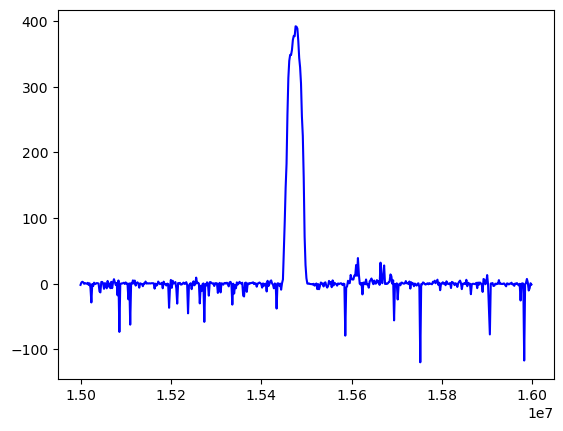

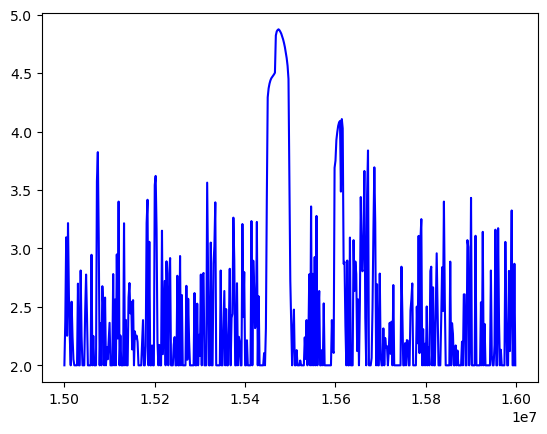

In [56]:
plt.plot(malResultsdf["position"],malResultsdf["lnCL diff"],color='b')
plt.show()

plt.plot(malResultsdf["position"],malResultsdf["log10 alpha"],color='b')
plt.show()



<div class="alert alert-block alert-success">    
    <b>Exercise 13:</b> What additional information would we need to convert the estimate of alpha to an estimate of the strength of selection sb?
</div>

Solution:

We would need to know the effective population size and the per-base recombination rate.

<div class="alert alert-block alert-success">    
    <b>Exercise 14:</b> use <code>allel.windowed_diversity</code> again to plot genetic diversity for 50_000 bp windows in the genome region that we tested. Does this confirm the results we obtained from sweepfinder? 
</div>

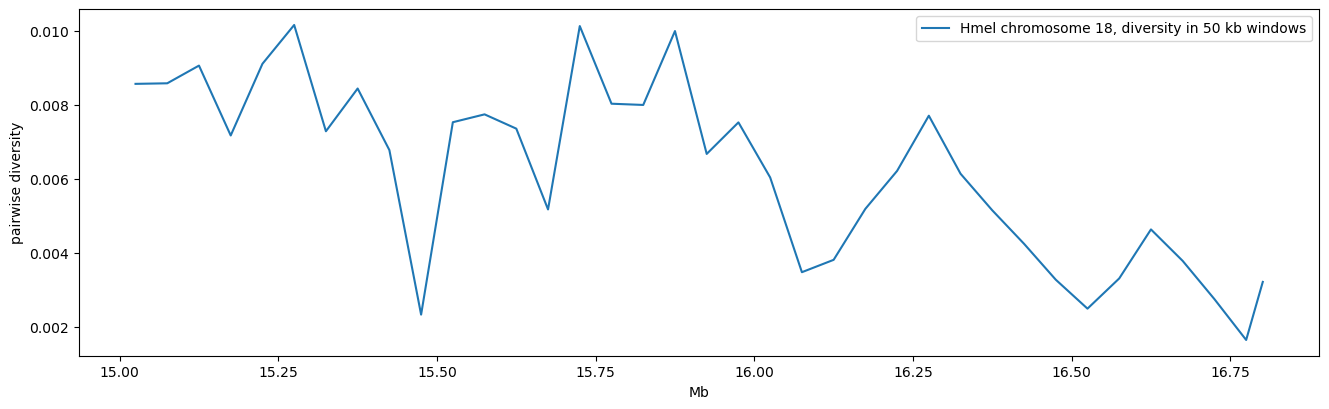

In [57]:
# Sol:

pi_mal_wins, windows, n_bases, counts = allel.windowed_diversity(ba_positions, ba_mal_counts, size=50_000, 
                                                                 start=int(leftLimTestSites), stop=ba_positions[-1])

window_stats = pd.DataFrame(pi_mal_wins, columns = ['pi_mal']);
window_stats["coordinates"] =  windows.mean(axis=1)/1_000_000
fig, ax = plt.subplots(figsize=(16,9/2))
sns.lineplot(x=window_stats["coordinates"], y=window_stats["pi_mal"], label='Hmel chromosome 18, diversity in 50 kb windows')
plt.xlabel('Mb')
plt.ylabel('pairwise diversity')
plt.show()

## Indeed, we see a clear and sharp valley of genetic diversity in the region surrounding our candidate sweep site 